In [1]:
import matplotlib.pyplot as plt

from models.GA.baseChromosome import LinearChromosome, Chromosome
import copy
import torch
import torch.nn as nn
from models.TS.GRUPipeline import GRUFrac
from torch.utils.data import DataLoader, TensorDataset
from models.GA.raw import cycle

import boto3

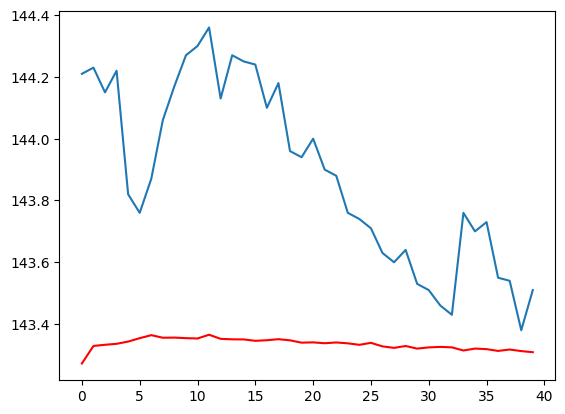

In [2]:
SYMBOL = "SOLUSDT"
session = boto3.session.Session()
s3 = session.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id='YCAJEEvXFkR_Vlz_q0TNbK1f7',
    aws_secret_access_key='YCPw07kPNEgOJVF0N93yReOErAl7RP0-5woP_Bgl',
    region_name='ru-central1'
)
bucket_name = 'test-actions'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_file = f'train/train_{SYMBOL}.pt'
s3.download_file(bucket_name, train_file, train_file[6:])
train_file = torch.load(train_file[6:], weights_only=True).to(torch.float32).to(device)
train_dataset = TensorDataset(train_file)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    
train_file = f'train/all_price_{SYMBOL}.pt'
s3.download_file(bucket_name, train_file, train_file[6:])
all_price = torch.load(f'all_price_{SYMBOL}.pt', weights_only=True).to(torch.float32).to(device)
mean, std = all_price.detach().mean().item(), all_price.detach().std().item()
differed = torch.diff(all_price)
std_d = differed.std()
    
gru = GRUFrac(1, 40, 4, 1, mean=mean, scale=std, activation=nn.ReLU(), std_d=std_d)
s3.download_file(bucket_name, f'model/weights_{SYMBOL}.pt', f'weights_{SYMBOL}.pt')
gru.load_state_dict(torch.load(f'weights_{SYMBOL}.pt', weights_only=False, map_location=torch.device(device)))
length = 40
train_x = torch.stack([all_price[i:i+length].reshape(length, 1) for i in range(all_price.shape[0] - length)]).to(device)
train_y = torch.tensor([all_price[length+i] for i in range(all_price.shape[0] - length)]).reshape(all_price.shape[0] - length, 1).to(device)
start = 5900
l=40
plt.plot(train_y.squeeze()[start+length:start+l+length])
plt.plot(gru.predict(train_x[start].reshape(1, length, 1), l).squeeze()[length:].detach().numpy(), color="red")
plt.show()


In [2]:
symbols = ['SOLUSDT', "APEXUSDT", "BTCUSDT", "ETHUSDT", "MNTUSDT", "PEPEUSDT", "SUIUSDT", "XRPUSDT"]

session = boto3.session.Session()
s3 = session.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id='YCAJEEvXFkR_Vlz_q0TNbK1f7',
    aws_secret_access_key='YCPw07kPNEgOJVF0N93yReOErAl7RP0-5woP_Bgl',
    region_name='ru-central1'
)
bucket_name = 'test-actions'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for symbol in symbols:
    print(f'loading data {symbol}')
    
    train_file = f'train/train_{symbol}.pt'
    s3.download_file(bucket_name, train_file, train_file[6:])
    train_data = torch.load(train_file[6:], weights_only=True).to(torch.float32).to(device)
    train_data = train_data[:2]
    train_dataset = TensorDataset(train_data)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    
    train_file = f'train/all_price_{symbol}.pt'
    s3.download_file(bucket_name, train_file, train_file[6:])
    all_price = torch.load(f'all_price_{symbol}.pt', weights_only=True).to(torch.float32).to(device)
    mean, std = all_price.detach().mean().item(), all_price.detach().std().item()
    differed = torch.diff(all_price)
    std_d = differed.std()
    
    gru = GRUFrac(1, 40, 4, 1, mean=mean, scale=std, activation=nn.ReLU(), std_d=std_d)
    s3.download_file(bucket_name, f'model/weights_{symbol}.pt', f'weights_{symbol}.pt')
    gru.load_state_dict(torch.load(f'weights_{symbol}.pt', weights_only=False, map_location=torch.device(device)))
    
    start_pop = [LinearChromosome(input_size=1, hidden_size=30, pred_model=copy.deepcopy(gru).eval(),                pred_length=20).to(device),
                 LinearChromosome(input_size=1, hidden_size=30, pred_model=copy.deepcopy(gru).eval(), pred_length=20).to(device),
                 LinearChromosome(input_size=1, hidden_size=30, pred_model=copy.deepcopy(gru).eval(), pred_length=20).to(device),
                 #LinearChromosome(input_size=1, hidden_size=30, pred_model=copy.deepcopy(gru).eval(), pred_length=20).to(device)
                 ]

    weights_file = f'ga_weights_{symbol}.pt'
    weights = cycle(start_pop, train_dataloader, 100, 0.01, parents_number=6, new_pop=36) #  state dict
    torch.save(weights, weights_file)
    s3.upload_file(weights_file, bucket_name, 'ga/model/'+weights_file)

loading data SOLUSDT
step: 0
i: 0
i: 1
i: 2
epoch: 1, reward: 1.8591
step: 0
i: 0
i: 1
i: 2
epoch: 2, reward: 6.3990
step: 0
i: 0
i: 1
i: 2
epoch: 3, reward: 11.6128
step: 0
i: 0
i: 1
i: 2
epoch: 4, reward: 5.7847
step: 0
i: 0
i: 1
i: 2
epoch: 5, reward: 6.7489
step: 0
i: 0
i: 1
i: 2
epoch: 6, reward: 9.3179
step: 0
i: 0
i: 1
i: 2
epoch: 7, reward: 10.1007
step: 0


KeyboardInterrupt: 

In [17]:
a = all_price[:100]
print(train_x[:5])
print(torch.mean(a, dim=-1, keepdim=True))


tensor([[[156.9400],
         [157.1000],
         [157.0300],
         [157.1200],
         [156.8100],
         [156.8600],
         [157.0000],
         [157.1700],
         [157.1200],
         [157.2200],
         [157.1200],
         [157.1700],
         [157.3100],
         [157.1800],
         [157.1400],
         [156.9600],
         [157.0700],
         [156.9700],
         [156.9800],
         [156.9300],
         [156.9300],
         [156.5700],
         [156.7700],
         [156.7000],
         [156.7400],
         [156.8000],
         [156.7500],
         [156.5600],
         [156.5500],
         [156.4000],
         [156.5000],
         [156.8600],
         [156.6200],
         [156.6700],
         [156.6500],
         [156.5500],
         [156.6000],
         [156.4500],
         [156.6300],
         [156.9200]],

        [[157.1000],
         [157.0300],
         [157.1200],
         [156.8100],
         [156.8600],
         [157.0000],
         [157.1700],
         [1